In [1]:
import xarray as xr
import numpy as np
import pylab as plt
import cartopy.crs as ccrs
import cmocean
import copy as cp
from scipy.interpolate import griddata, interp1d
import pickle
import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.cm import get_cmap
import cartopy as cr
import matplotlib.cm as cm
from datetime import datetime as dtime
import matplotlib.colors as colors

# Definition des sections

In [2]:
def re_grid_fucking_ORCA(Aplot):
    # Make the new grid
    lons_1d=np.linspace(0, 360, 721)
    lats_1d=np.linspace(65, 90, 51)
    lons_2d, lats_2d = np.meshgrid(lons_1d, lats_1d)
    try:
        lons=Aplot.Lons_360.values
    except:
        lons = cp.deepcopy(Aplot.llon_cc.values)
        lons[lons<0] = lons[lons<0]+360
    try:
        lats=Aplot.llat_cc.values
    except:
        lats = Aplot.nav_lat.values
    temp=Aplot.values
    lons=lons.flatten()
    lats=lats.flatten()
    temp=temp.flatten()

    
    temp_new = griddata((lons, lats), temp, (lons_2d, lats_2d), method='linear')
    
    dint = xr.Dataset(data_vars = {'Lats_reg':lats_1d, 'Lons_reg_360':lons_1d})
    dint['val'] = (('Lats_reg', 'Lons_reg_360'), temp_new)
    return dint

In [3]:
# Load
ds_zgr =  xr.open_dataset('/storage/nplanat/Glorys12_masks/Mask_zgr_12.nc')
ds_zgr = ds_zgr.set_coords('nav_lat')
ds_zgr = ds_zgr.set_coords('nav_lon')
dsT = xr.open_dataset('/storage/nplanat/Glorys12_ORCA_mensuel/ext_arctic-GLORYS12V1_ORCA12_199408_gridT.nc')
dsT = dsT.set_coords('nav_lat')
dsT = dsT.set_coords('nav_lon')

Lons_360 = dsT.nav_lon.values
for x in range(dsT.nav_lon.shape[0]):
    for y in range(dsT.nav_lat.shape[1]):
        if Lons_360[x,y]<0:
            Lons_360[x,y] +=360
ds_zgr['Lons_360'] = (('y', 'x'), Lons_360)
ds_zgr = ds_zgr.set_coords('Lons_360')

bathy = re_grid_fucking_ORCA(ds_zgr.mbathy[0,:,:])

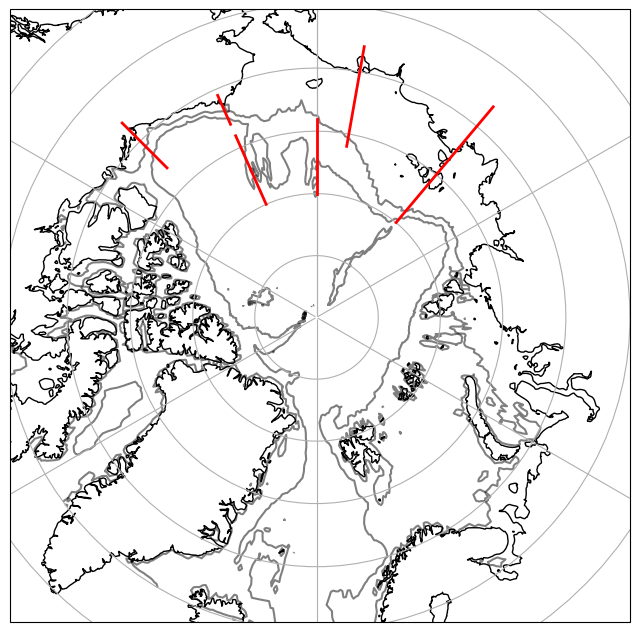

In [4]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1,1,1,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
ax.gridlines()
#ax.add_feature(cfeature.LAND)

ax.set_extent([-200, 90, 65, 90], crs=ccrs.PlateCarree())
bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       

lo = -156
la_m = 70.5; la_M = 73
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'r', lw = 2)

lo = -135
la_m = 68; la_M = 73
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'r', lw = 2)

lo = 140
la_m = 68; la_M = 80
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'r', lw = 2)

lo = 170
la_m = 68; la_M = 76
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'r', lw = 2)

lo = -156
la_m = 74; la_M = 80
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'r', lw = 2)

lo = 180
la_m = 74; la_M = 80
ax.plot(np.ones(50)*lo, np.linspace(la_m, la_M, 50),  transform=ccrs.PlateCarree(), c = 'r', lw = 2)

In [5]:
def get_ind_sections(LAT, LON):
    L_ACC = []
    L_PB = []
    L_CB = []
    L_PB_CB = []
    L_EU = []
    L_SZ = []
    L_ESB = []
    L_PB_ESB = []
    for n in range(LAT.shape[0]):
        if np.any(np.logical_and(LON[n,:]>225,  LAT[n,:]<73)):
            L_ACC.append(n)
        if np.any(np.logical_and(np.logical_and(LON[n,:]>204, LON[n,:]<206), LAT[n,:]<73)):
            L_PB.append(n)
        if np.any(np.logical_and(np.logical_and(np.logical_and(LON[n,:]>202, LON[n,:]<204), LAT[n,:]>74), LAT[n,:]<80)) and LON[n,:][-1]>204:
            L_CB.append(n)
        if np.any(np.logical_and(np.logical_and(np.logical_and(LON[n,:]>202, LON[n,:]<204), LAT[n,:]>74), LAT[n,:]<80)) and LON[n,:][-1]>204 and np.any(np.logical_and(np.logical_and(LON[n,:]>204, LON[n,:]<206), LAT[n,:]<73)):
            L_PB_CB.append(n)

        if np.any(np.logical_and(np.logical_and(LON[n,:]>169, LON[n,:]<170), LAT[n,:]<76)):
            L_EU.append(n)

        if np.any(np.logical_and(np.logical_and(LON[n,:]>139, LON[n,:]<140), LAT[n,:]<80)):
            L_SZ.append(n)

        if np.any(np.logical_and(np.logical_and(np.logical_and(LON[n,:]>179, LON[n,:]<180), LAT[n,:]<80), LAT[n,:]>74)):
            L_ESB.append(n)
        if np.any(np.logical_and(np.logical_and(LON[n,:]>204, LON[n,:]<206), LAT[n,:]<73)) and np.any(np.logical_and(np.logical_and(np.logical_and(LON[n,:]>179, LON[n,:]<180), LAT[n,:]<80), LAT[n,:]>74)):
            L_PB_ESB.append(n)
    return L_ACC, L_PB, L_CB, L_PB_CB, L_EU, L_SZ, L_ESB, L_PB_ESB

In [6]:
yr = 0
Dates_all = []; NMB_all = []; 

L_ACC = np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_ACC_%i'%yr+'.npy')
L_PB = np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_PB_%i'%yr+'.npy')
L_CB =np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_CB_%i'%yr+'.npy')
L_PB_CB =np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_PB_CB_%i'%yr+'.npy')
L_SZ =np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_SZ_%i'%yr+'.npy')
L_ESB =np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_ESB_%i'%yr+'.npy')
L_PB_ESB =np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_PB_ESB_%i'%yr+'.npy')
L_EU =np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_EU_%i'%yr+'.npy')
time_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/times_%i'%yr+'.npy', allow_pickle = True)
Date_data = np.unique(time_yr)
Dates_all.extend(Date_data)    
NMB_courrant = np.zeros((len(Date_data), 9))
labs_yr_ACC = np.zeros(len(time_yr))
labs_yr_PB = np.zeros(len(time_yr))
labs_yr_CB = np.zeros(len(time_yr))
labs_yr_PB_CB = np.zeros(len(time_yr))
labs_yr_ESB = np.zeros(len(time_yr))
labs_yr_PB_ESB = np.zeros(len(time_yr))
labs_yr_EU = np.zeros(len(time_yr))
labs_yr_SZ = np.zeros(len(time_yr))

labs_yr_ACC[np.array(L_ACC)] =1
labs_yr_PB[np.array(L_PB)] =2
labs_yr_CB[np.array(L_CB)] =3
labs_yr_PB_CB[np.array(L_PB_CB)] =4
try:
    labs_yr_SZ[np.array(L_SZ)] =5
except:
    print('No SZ in '+str(yr))
labs_yr_ESB[np.array(L_ESB)] =6
labs_yr_EU[np.array(L_EU)] =7
labs_yr_PB_ESB[np.array(L_PB_ESB)] =8


for i in range(len(Date_data)):
    d0 = np.where(Date_data[i] ==time_yr)[0]
    print(d0)
    for di in d0:
        NMB_courrant[i,int(labs_yr_ACC[di])] +=1
        NMB_courrant[i,int(labs_yr_PB[di])] +=1
        NMB_courrant[i,int(labs_yr_CB[di])] +=1
        NMB_courrant[i,int(labs_yr_PB_CB[di])] +=1
        NMB_courrant[i,int(labs_yr_ESB[di])] +=1
        NMB_courrant[i,int(labs_yr_PB_ESB[di])] +=1
        NMB_courrant[i,int(labs_yr_EU[di])] +=1
        NMB_courrant[i,int(labs_yr_SZ[di])] +=1
NMB_all.extend(NMB_courrant)
NMB_all = np.array(NMB_all)
labs_yr_ACC

IndexError: index 756 is out of bounds for axis 0 with size 753

In [ ]:
def get_sections_classic(yr):
    Dates_all = []; NMB_all = []; 
    
    L_ACC = np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_ACC_%i'%yr+'.npy')
    L_PB = np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_PB_%i'%yr+'.npy')
    L_CB =np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_CB_%i'%yr+'.npy')
    L_PB_CB =np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_PB_CB_%i'%yr+'.npy')
    L_SZ =np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_SZ_%i'%yr+'.npy')
    L_ESB =np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_ESB_%i'%yr+'.npy')
    L_PB_ESB =np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_PB_ESB_%i'%yr+'.npy')
    L_EU =np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/L_EU_%i'%yr+'.npy')
    time_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/SENSITIVITY/times_%i'%yr+'.npy', allow_pickle = True)
    Date_data = np.unique(time_yr)
    Dates_all.extend(Date_data)    
    NMB_courrant = np.zeros((len(Date_data), 9))

    labs_yr_ACC = np.zeros(len(time_yr))
    labs_yr_PB = np.zeros(len(time_yr))
    labs_yr_CB = np.zeros(len(time_yr))
    labs_yr_PB_CB = np.zeros(len(time_yr))
    labs_yr_ESB = np.zeros(len(time_yr))
    labs_yr_PB_ESB = np.zeros(len(time_yr))
    labs_yr_EU = np.zeros(len(time_yr))
    labs_yr_SZ = np.zeros(len(time_yr))

    labs_yr_ACC[np.array(L_ACC)] =1
    labs_yr_PB[np.array(L_PB)] =2
    labs_yr_CB[np.array(L_CB)] =3
    labs_yr_PB_CB[np.array(L_PB_CB)] =4
    try:
        labs_yr_SZ[np.array(L_SZ)] =5
    except:
        print('No SZ in '+str(yr))
    labs_yr_ESB[np.array(L_ESB)] =6
    labs_yr_EU[np.array(L_EU)] =7
    labs_yr_PB_ESB[np.array(L_PB_ESB)] =8

    for i in range(len(Date_data)):
        d0 = np.where(Date_data[i] ==time_yr)[0]
        for di in d0:
            NMB_courrant[i,int(labs_yr_ACC[di])] +=1
            NMB_courrant[i,int(labs_yr_PB[di])] +=1
            NMB_courrant[i,int(labs_yr_CB[di])] +=1
            NMB_courrant[i,int(labs_yr_PB_CB[di])] +=1
            NMB_courrant[i,int(labs_yr_ESB[di])] +=1
            NMB_courrant[i,int(labs_yr_PB_ESB[di])] +=1
            NMB_courrant[i,int(labs_yr_EU[di])] +=1
            NMB_courrant[i,int(labs_yr_SZ[di])] +=1

        #NMB_courrant[i,:] =100*NMB_courrant[i,:]/len(d0)
    NMB_all.extend(NMB_courrant)
    NMB_all = np.array(NMB_all)
    return NMB_all, Dates_all

In [ ]:
def lon_360(lon):
    LON = cp.deepcopy(lon)
    LON[LON<0] = LON[LON<0]+360
    return LON

In [ ]:
def running_mean(t, x, N) :
    rm = np.convolve(x, np.ones((N,))/N, mode='valid')
    times = t[int(N/2):len(rm)+int(N/2)]
    return times, rm

# Define metrics on one experiment

In [ ]:
Liste_files = [x for x in sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_*.nc')) if not (x[44] in ['s', 'm', 'n']) ]

In [ ]:
# '/storage/nplanat/Glorys12_OP_journalier/ADV_20_50_60_None_1993_0_1993.nc',

Liste_files

In [ ]:
f = plt.figure(figsize = (8,4))
ax = f.add_subplot(1,1,1)
cmap = plt.cm.jet(np.linspace(0,1,9))
Names = ['-', 'ACC', 'PB', 'CB', 'PB_CB', 'SZ', 'ESB','EU', 'PB_ESB']

for i in range(len(Liste_files)):
    ds = xr.open_dataset(Liste_files[i])
    L_ACC, L_PB, L_CB, L_PB_CB, L_EU, L_SZ, L_ESB, L_PB_ESB = get_ind_sections(ds.lat.values,lon_360(ds.lon.values))
    All = np.unique(np.concatenate([L_ACC, L_PB, L_CB, L_PB_CB, L_EU, L_SZ, L_ESB, L_PB_ESB], axis = 0))
    Prop = np.zeros(9)
    Npart = ds.lon.shape[0]
    Prop[0] = (Npart - len(All))/Npart
    Prop[1] = len(L_ACC)/Npart
    Prop[2] = len(L_PB)/Npart
    Prop[3] = len(L_CB)/Npart
    Prop[4] = len(L_PB_CB)/Npart
    Prop[5] = len(L_EU)/Npart
    Prop[6] = len(L_SZ)/Npart
    Prop[7] = len(L_ESB)/Npart
    Prop[8] = len(L_PB_ESB)/Npart
    for j in range(1,9):
        ax.plot(i, Prop[j], '.', label = Names[j], ls= ':', c = cmap[j])
